# Lab03

## Neural Network Example
We are going to implement a Neural Network for identifying animal species using features of animals.

In [39]:
import torch
import numpy as np

Let's say we have two features that represent the following two aspects: 
1. Does the animal have hair? 
2. Does the animal have feathers?



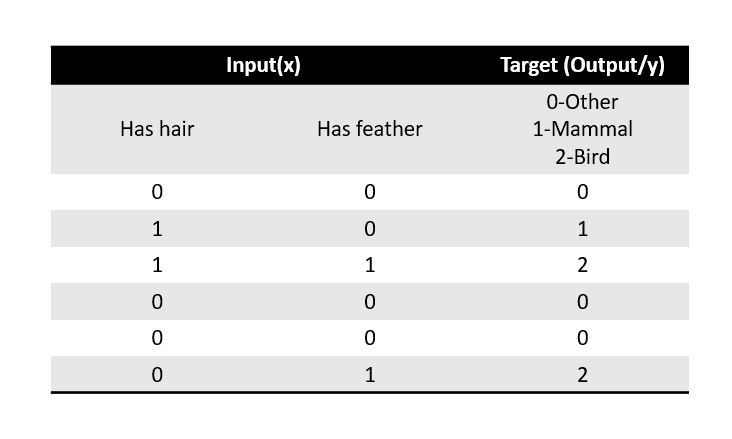

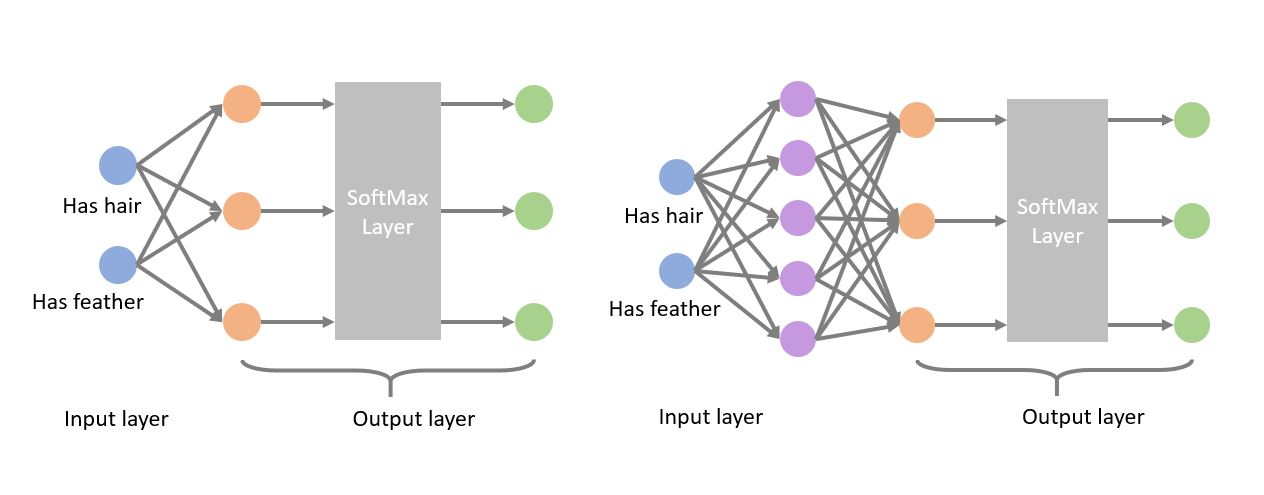

We would like to predict whether the animal is a bird, a mammal, or something else.

In [40]:
# Create our feature data 
# [Hair, Feather]: 0 means doesn't have, 1 means have 
# e.g. [1, 0] indicates the animal has hair and doesn't have feathers
x_data = np.array(
    [[0, 0], [1, 0], [1, 1], [0, 0], [0, 0], [0, 1]])

# We need to transform the data into Torch data type to be used in Pytorch
x_data_torch = torch.from_numpy(x_data).float() 
# Uncomment the following line to print out if you want to see the details
print(x_data_torch.shape) 

y_data = np.array([0,1,2,0,0,2]) # 0-Other  1-Mammal  2-Bird
y_data_torch = torch.from_numpy(y_data)
# Uncomment the following line to print out if you want to see the details
# print(y_data_torch) 

# number of input (features), 2 - Hair, Feather
num_features = 2
# number of output (classes), 3 - Other, Mammal, Bird
num_classes = 3

torch.Size([6, 2])


### No hidden layer with Manual Parameter Update

Build a classification model without hidden layer.
We manually update parameters (weight and bias) in this example.

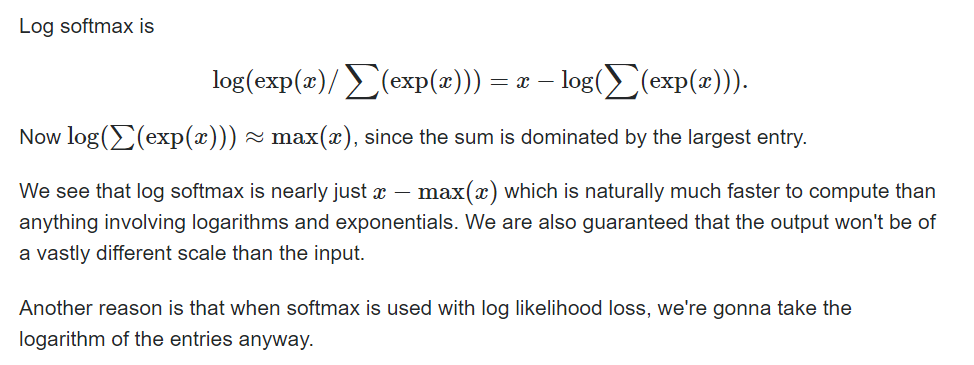

In [41]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# Initialize Weight and Bias manually, and setup the gradient
# torch.randn returns a tensor filled with random numbers from a normal distribution with mean 0 and variance 1 (also called the standard normal distribution)
W1 = torch.randn(num_features, num_classes, requires_grad=True) # to ensure the output is 6x3
B1 = torch.randn(num_classes, requires_grad=True)

# Learning Rate - determines the step size at each iteration while moving toward a minimum of a loss function
learning_rate=0.01

# Epoch - A measure of the number of times all of the training vectors are used once to update the weights.
number_of_epochs = 1000 # TODO: try 2000 epochs and see how it goes

for epoch in range(number_of_epochs): 

    # forward propagataion - the calculation and storage of intermediate variables (incl. outputs) from the input layer to the output layer
    z = torch.add(torch.matmul(x_data_torch, W1), B1)

    # softmax changes each value to be between 0 and 1, and all values will add up to 1
    # i.e. [8.04, 2.76, -6.52] -> [0.53 0.24 0.23]
    # log_softmax applies logarithm after softmax.
    # softmax: exp(x_i) / exp(x).sum() and log_softmax: log( exp(x_i) / exp(x).sum() )
    # log_softmax essential does log(softmax(x)), but the practical implementation is different and more efficient
    # https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax
    log_softmax = F.log_softmax(z,dim=1) # output < 0

    # calculate the negative log likelihood loss
    loss = F.nll_loss(log_softmax, y_data_torch)

    # back propagation
    loss.backward()  #calculate gradient
    with torch.no_grad(): # When doing back propagation, do not accumalte gradient
        W1.data -= learning_rate*W1.grad.data #Gradient descent
        B1.data -= learning_rate*B1.grad.data
    W1.grad.data.zero_() # reset the gradient
    B1.grad.data.zero_()

    if epoch % 200 == 199: 
        with torch.no_grad(): # prediction section does not require gradient 
            pred_outputs = torch.add(torch.matmul(x_data_torch ,W1),B1)
            predicted = torch.argmax(pred_outputs, 1)
            train_acc = accuracy_score(predicted.numpy(),y_data)
            print('Epoch: %d, loss: %.4f, train_acc: %.3f' %(epoch + 1, loss.item() , train_acc))

# Result
print('Predicted :', predicted.numpy())
print('Truth :', y_data)
print('Accuracy : %.2f' %train_acc)

Epoch: 200, loss: 1.0050, train_acc: 0.833
Epoch: 400, loss: 0.8069, train_acc: 0.833
Epoch: 600, loss: 0.6805, train_acc: 0.833
Epoch: 800, loss: 0.5855, train_acc: 0.833
Epoch: 1000, loss: 0.5109, train_acc: 0.833
Predicted : [0 0 2 0 0 2]
Truth : [0 1 2 0 0 2]
Accuracy : 0.83


### No hidden layer with the Optimiser


In [42]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Build a neural network model rather than initializing the parameters manually
# torch.nn.Linear applies a linear transformation to the input data: y=Ax+b
# https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
class ModelWithoutHiddenLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(ModelWithoutHiddenLayer, self).__init__()
        self.linear = nn.Linear(input_size, output_size) # This coresponds to W1,B1

    def forward(self, x):
        x = self.linear(x)
        return x

# Initialize the model
model = ModelWithoutHiddenLayer(num_features, num_classes)

# learning rate
learning_rate=0.01

# calculate negative log likelihood loss
criterion = nn.NLLLoss()

# Define the optimiser
# Pass the model parameters to be updated, and setup the learning rate when calling optim.SGD
# Please find the detailed information about the SGD optimiser in PyTorch (https://pytorch.org/docs/stable/optim.html).
optimiser = optim.SGD(model.parameters(), lr=learning_rate) 

# epochs
no_of_epochs = 1000

# For every epoch, the model weights will be modified using the given learning rate
for epoch in range(no_of_epochs):  

    # get the input and label
    inputs = x_data_torch
    labels = y_data_torch

    # set the module in training mode (for illustration)
    # a module can be set to training mode (net.train(mode=True)) or evaluation mode (when net.train(mode=False) or net.eval())
    # This has effect only on certain modules such as Dropout, BtchNorm etc.
    model.train() # mode=True by default

    # set the gradients to zero
    optimiser.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(F.log_softmax(outputs,dim=1), labels)
    loss.backward()
    optimiser.step() # back propagation

    if epoch % 200 == 199:    # print every 200 epochs
        model.eval() # we are using the model to predict here, i.e. set the module to evaluation mode
        pred_outputs = model(inputs)
        predicted = torch.argmax(pred_outputs, 1)
        train_acc = accuracy_score(predicted.numpy(),y_data)
        print('%d, loss: %.3f, train_acc: %.3f' %(epoch + 1, loss.item(), train_acc))


print('Finished Training')

# Result
model.eval()
pred_outputs = model(inputs)
predicted = torch.argmax(pred_outputs, 1)
print('Predicted :', predicted.numpy())
print('Truth :', y_data)

train_acc = accuracy_score(predicted.numpy(),y_data)
print('Accuracy : %.2f' %train_acc)

200, loss: 0.795, train_acc: 0.833
400, loss: 0.666, train_acc: 0.833
600, loss: 0.571, train_acc: 1.000
800, loss: 0.498, train_acc: 1.000
1000, loss: 0.439, train_acc: 1.000
Finished Training
Predicted : [0 1 2 0 0 2]
Truth : [0 1 2 0 0 2]
Accuracy : 1.00


### Hidden Layer with Manual Parameter Update

In [43]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# you can find the detailed comment and explanation in the section - no hidden layer with manual parameter update section 

# number of neurons in hidden layer, 
n_hidden_1 = 5

# [Input(Features), Output(number of neurons in hidden layer)]
W1 = torch.randn(num_features, n_hidden_1, requires_grad=True)

# Let Hidden Layer Bias the number of output candidates, which is 5 (number of neurons in hidden layer).
B1 = torch.randn(n_hidden_1, requires_grad=True)

# [Input(number of neurons in hidden layer), Output(Classes)]
Wout = torch.randn(n_hidden_1, num_classes, requires_grad=True)

# Let Bias the number of output candidates, which is 3 (number of classes).
Bout = torch.randn(num_classes, requires_grad=True)

learning_rate=0.01
no_of_epochs = 1000

for epoch in range(no_of_epochs):    
    z1 = torch.add(torch.matmul(x_data_torch, W1), B1) # linear function
    Zout = torch.add(torch.matmul(F.relu(z1), Wout), Bout)

    log_softmax = F.log_softmax(Zout,dim=1) # dim1: based on row
    loss = F.nll_loss(log_softmax, y_data_torch)

    loss.backward()
    with torch.no_grad():
        W1.data -= learning_rate*W1.grad.data
        B1.data -= learning_rate*B1.grad.data
        Wout.data -= learning_rate*Wout.grad.data
        Bout.data -= learning_rate*Bout.grad.data

    W1.grad.data.zero_()
    B1.grad.data.zero_()
    Wout.grad.data.zero_()
    Bout.grad.data.zero_()

    if epoch % 200 == 199: 
        with torch.no_grad():
            z1 = torch.add(torch.matmul(x_data_torch ,W1),B1)
            Zout = torch.add(torch.matmul(F.relu(z1) ,Wout),Bout)
            predicted = torch.argmax(Zout, 1)
            train_acc = accuracy_score(predicted.numpy(),y_data)
            print('Epoch: %d, loss: %.4f, train_acc: %.3f' %(epoch + 1, loss.item() , train_acc))
print("Finished")
# Result
print('Predicted :', predicted.numpy())
print('Truth :', y_data)
print('Accuracy : %.2f' %train_acc)

Epoch: 200, loss: 0.9655, train_acc: 0.333
Epoch: 400, loss: 0.7722, train_acc: 0.667
Epoch: 600, loss: 0.6353, train_acc: 0.833
Epoch: 800, loss: 0.5224, train_acc: 0.833
Epoch: 1000, loss: 0.4230, train_acc: 1.000
Finished
Predicted : [0 1 2 0 0 2]
Truth : [0 1 2 0 0 2]
Accuracy : 1.00


### Hidden Layer with the Optimiser


In [44]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#you can find the detailed comment and explanation in the section - no hidden layer with the optimiser section 


class ModelWithHiddenLayer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ModelWithHiddenLayer, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        z1 = self.linear1(x)
        Zout = self.linear2(F.relu(z1))
        return Zout

model = ModelWithHiddenLayer(num_features, n_hidden_1, num_classes)

learning_rate=0.01
no_of_epochs = 1000

# If you apply Pytorch’s CrossEntropyLoss to your output layer,
# you get the same result as applying Pytorch’s NLLLoss to a LogSoftmax layer added after your original output layer.
criterion = nn.CrossEntropyLoss() 
optimiser = optim.SGD(model.parameters(), lr=learning_rate)


from sklearn.metrics import accuracy_score

for epoch in range(no_of_epochs):  # loop over the dataset multiple times

    # get the inputs
    inputs = x_data_torch
    labels = y_data_torch

    model.train()
    # zero the parameter gradients
    optimiser.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels) # We don't need to calcualte logsoftmax here
    loss.backward()
    optimiser.step()

    # print statistics
    if epoch % 200 == 199:    # print every 200 epochs
        model.eval()
        pred_outputs = model(inputs)
        predicted = torch.argmax(pred_outputs, 1)
        train_acc = accuracy_score(predicted.numpy(),y_data)
        print('%d, loss: %.4f, train_acc: %.4f' %(epoch + 1, loss.item(), train_acc))

print('Finished Training')

# Result
pred_outputs = model(inputs)
_, predicted = torch.max(pred_outputs, 1)
print('Predicted :', predicted.numpy())
print('Truth :', y_data)

train_acc = accuracy_score(predicted.numpy(),y_data)
print('Accuracy : %.2f' %train_acc)

200, loss: 0.9924, train_acc: 0.5000
400, loss: 0.9242, train_acc: 0.5000
600, loss: 0.8559, train_acc: 0.5000
800, loss: 0.7792, train_acc: 0.8333
1000, loss: 0.6929, train_acc: 0.8333
Finished Training
Predicted : [0 1 2 0 0 0]
Truth : [0 1 2 0 0 2]
Accuracy : 0.83


## Word2Vec on Pytorch
Let's try to implement Word2Vec - Skip Gram with Neural Network via Pytorch

In [45]:
sentences = ["he likes cat",
             "he likes dog",
             "he likes animal",
             "dog cat animal",
             "she likes cat",
             "she dislikes dog",
             "cat likes fish",
             "cat likes milk",
             "dog likes bone",
             "dog dislikes fish",
             "dog likes milk",
             "she likes movie",
             "she likes music",
             "he likes game",
             "he likes movie",
             "cat dislikes dog"]

# convert all sentences to unique word list
word_list = " ".join(sentences) # join these single sentence with " "
print(word_list)
word_list = " ".join(sentences).split() # split strings into a list
print(word_list)
word_list = list(set(word_list)) # remove repeated words
print(word_list)
# make dictionary so that we can reference each index of unique word
word_dict = {w: i for i, w in enumerate(word_list)}
print(word_dict)

he likes cat he likes dog he likes animal dog cat animal she likes cat she dislikes dog cat likes fish cat likes milk dog likes bone dog dislikes fish dog likes milk she likes movie she likes music he likes game he likes movie cat dislikes dog
['he', 'likes', 'cat', 'he', 'likes', 'dog', 'he', 'likes', 'animal', 'dog', 'cat', 'animal', 'she', 'likes', 'cat', 'she', 'dislikes', 'dog', 'cat', 'likes', 'fish', 'cat', 'likes', 'milk', 'dog', 'likes', 'bone', 'dog', 'dislikes', 'fish', 'dog', 'likes', 'milk', 'she', 'likes', 'movie', 'she', 'likes', 'music', 'he', 'likes', 'game', 'he', 'likes', 'movie', 'cat', 'dislikes', 'dog']
['movie', 'music', 'she', 'fish', 'dislikes', 'cat', 'bone', 'animal', 'game', 'dog', 'he', 'likes', 'milk']
{'movie': 0, 'music': 1, 'she': 2, 'fish': 3, 'dislikes': 4, 'cat': 5, 'bone': 6, 'animal': 7, 'game': 8, 'dog': 9, 'he': 10, 'likes': 11, 'milk': 12}


In [46]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Raw data - setences
# Let's create a toy data for simplicity 
sentences = ["he likes cat",
             "he likes dog",
             "he likes animal",
             "dog cat animal",
             "she likes cat",
             "she dislikes dog",
             "cat likes fish",
             "cat likes milk",
             "dog likes bone",
             "dog dislikes fish",
             "dog likes milk",
             "she likes movie",
             "she likes music",
             "he likes game",
             "he likes movie",
             "cat dislikes dog"]

# convert all sentences to unique word list
word_list = " ".join(sentences).split()
word_list = list(set(word_list))

# make dictionary so that we can reference each index of unique word
word_dict = {w: i for i, w in enumerate(word_list)}


# make window size=1 for skip-gram
# i.e.) he likes cat
#   -> (he, [likes]), (likes,[he, cat]), (cat,[likes])
#   -> (he, likes), (likes, he), (likes, cat), (cat, likes)
skip_grams = []

for sentence in sentences:
    sentence = sentence.split()
    for i in range(len(sentence)):
        centre = word_dict[sentence[i]] # get the index of he center word
        if i > 0 and i < len(sentence)-1:
            context = [word_dict[sentence[i - 1]], word_dict[sentence[i + 1]]] # get the index of context words
        elif i == 0:
            context = [word_dict[sentence[i + 1]]]
        else:
            context = [word_dict[sentence[i - 1]]]
        # context: returns the index of context words for each center word

        # skipgrams - (centre, context[0]), (centre, context[1])..
        # output: [[he, [likes], [likes, [he]], [likes, [cats]], [cats, [likes]]] => [[9, 12], [12, 9], [12, 1], [1, 12]]
        for w in context:
            skip_grams.append([centre, w])

In [47]:
print(skip_grams) # return [index(center), index(one context word)]

[[10, 11], [11, 10], [11, 5], [5, 11], [10, 11], [11, 10], [11, 9], [9, 11], [10, 11], [11, 10], [11, 7], [7, 11], [9, 5], [5, 9], [5, 7], [7, 5], [2, 11], [11, 2], [11, 5], [5, 11], [2, 4], [4, 2], [4, 9], [9, 4], [5, 11], [11, 5], [11, 3], [3, 11], [5, 11], [11, 5], [11, 12], [12, 11], [9, 11], [11, 9], [11, 6], [6, 11], [9, 4], [4, 9], [4, 3], [3, 4], [9, 11], [11, 9], [11, 12], [12, 11], [2, 11], [11, 2], [11, 0], [0, 11], [2, 11], [11, 2], [11, 1], [1, 11], [10, 11], [11, 10], [11, 8], [8, 11], [10, 11], [11, 10], [11, 0], [0, 11], [5, 4], [4, 5], [4, 9], [9, 4]]


In [48]:
voc_size = len(word_list) # how many words in this list

# prepare batch from skip-gram
# transfer the input words into one-hot encoding
def prepare_batch(data_temp):
    inputs = []
    labels = []

    for i in range(len(data_temp)):
        input_temp = [0]*voc_size # [0]*3 => [0, 0, 0]
        input_temp[data_temp[i][0]] = 1 # ont-hot input - data_temp[i][0]: the index of current center word, then make it becomes 1
        inputs.append(input_temp)  # centre - get the one-hot encoding of all center words
        labels.append(data_temp[i][1])  # context word - get the index of all context words

    return np.array(inputs), np.array(labels)

In [49]:
prepare_batch(skip_grams[:5])

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]), array([11, 10,  5, 11, 11]))

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from random import shuffle

batch_size = 16
learning_rate = 0.1
embedding_size = 2
no_of_epochs = 5000

W1 = torch.randn(voc_size, embedding_size, requires_grad=True)
Wout = torch.randn(embedding_size, voc_size, requires_grad=True)



for epoch in range(no_of_epochs):

    # shuffle the training set to make each epoch's batch different, you can also skip this step
    shuffle(skip_grams)
    loss_sum = 0

    for ind in range(0,len(skip_grams),batch_size):
        data_temp = skip_grams[ind : min(ind+batch_size, len(skip_grams))] # get the batch data
        inputs_temp, labels_temp = prepare_batch(data_temp) # get input center words with one-hot encoding format, and their labels(center words)
   
        inputs_torch = torch.from_numpy(inputs_temp).float()
        labels_torch = torch.from_numpy(labels_temp)

        hidden = torch.matmul(inputs_torch ,W1)
        out = torch.matmul(hidden,Wout)

        log_softmax = F.log_softmax(out,dim=1)
        loss = F.nll_loss(log_softmax, labels_torch)

        loss.backward()
        with torch.no_grad():
            W1.data -= learning_rate*W1.grad.data
            Wout.data -= learning_rate*Wout.grad.data
        W1.grad.data.zero_()
        Wout.grad.data.zero_()

        loss_sum += loss.item()

    if epoch % 500 == 499: 
        print('Epoch: %d, loss: %.4f' %(epoch + 1, loss_sum))


Epoch: 500, loss: 5.5006
Epoch: 1000, loss: 5.3443
Epoch: 1500, loss: 5.3291
Epoch: 2000, loss: 5.2942
Epoch: 2500, loss: 5.3152
Epoch: 3000, loss: 5.3291
Epoch: 3500, loss: 5.2940
Epoch: 4000, loss: 5.2982
Epoch: 4500, loss: 5.3112
Epoch: 5000, loss: 5.2841


In [52]:
# Get the trained projection matrix
trained_embeddings = W1.data.numpy()
print(trained_embeddings)
x, y = trained_embeddings[0]
print(x)
print(y)

[[ 0.995881    3.823955  ]
 [ 0.26422375  3.229331  ]
 [ 1.1311275   1.0593152 ]
 [ 1.683176    0.6394596 ]
 [-1.1758127  -4.4922338 ]
 [-2.0091934   1.2713848 ]
 [-1.4468391   3.1503847 ]
 [ 4.1519547   0.4393406 ]
 [-0.6046605   3.2245975 ]
 [ 3.4322903   0.54212934]
 [ 0.5975591   4.5409226 ]
 [ 0.01160288 -0.63780797]
 [ 0.595042    3.7818942 ]]
0.995881
3.823955


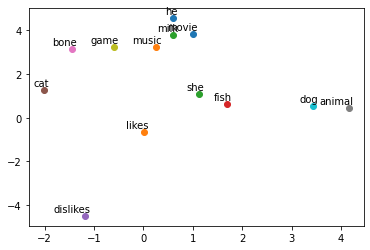

In [53]:
# Get the trained projection matrix
trained_embeddings = W1.data.numpy()
# Visualise result
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    # print (label, " : ", x, " " , y) # uncomment to see the detailed vector info
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()

# Exercise
Please complete the following **two questions** E1 and E2 and and submit your **"ipynb" file to Canvas**. (You can download it using "File" > "Download .ipynb"). Please make sure all code required to run your solution properly must be included in the submission file.





##E1. Briefly describe the impact of window size selection on the Word2Vec?
Please write down your answer below with your own words. 

In [55]:
#@Lab01 - E1

Answer = if two center words' window size are small (2-15), meaning the two center words may share very similar context, so they may be identified as being very similar between each other, which indicates they are interchangeable. In contrast, large window sizes(more than 5) lead to embeddings where similarity is more indicative of relatedness of the words. #@param {type:"raw"}

SyntaxError: ignored

##E2. CBOW implementation with PyTorch nn.Module and torch.optim

In the tutorial, we learned how to train a word2vec skip-gram model in pytorch with manually updates the parameters (weights). 


In this Lab 03 E2, please:

1.   use the "NN Model (**nn.Module**)" and the "Optimiser (**torch.optim**)" (that we learned in the above sections) to train a word2vec **CBOW (NOT Skip Gram)** model  on the provided toy data with widow_size=1 and embedding_size=2. 
2.   visualize (plot) the trained embeddings for each word in the vocabulary



Note: The embedding size should 2. The code for the preprocessing and the hyperparmeter setup are provided. Have fun!


In [56]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import shuffle
from sklearn.metrics import accuracy_score

# Raw data - sentences
# Let's create toy data for simplicity 
sentences = ["he likes cat",
             "he likes dog",
             "he likes animal",
             "dog cat animal",
             "she likes cat",
             "she dislikes dog",
             "cat likes fish",
             "cat likes milk",
             "dog likes bone",
             "dog dislikes fish",
             "dog likes milk",
             "she likes movie",
             "she likes music",
             "he likes game",
             "he likes movie",
             "cat dislikes dog"]

# convert all sentences to unique word list
word_list = " ".join(sentences).split()
word_list = list(set(word_list))


# make dictionary so that we can reference each index of unique word
word_dict = {w: i for i, w in enumerate(word_list)}

# make window size=1 for cbow
# i.e.) he likes cat
#   -> ([likes], he), ([he, cat], likes), ([likes], cat)
#   -> ([likes, likes], he), ([he, cat], likes), ([likes, likes], cat)
# Double the input when the word doesn't have two neighbours
# This will make your input have the same size, which will make it easier when you write the CBOW model code
# But this trick only works when window_size = 1

cbow = []

for sentence in sentences:
    sentence = sentence.split()
    for i in range(len(sentence)):
        centre = word_dict[sentence[i]]
        if i > 0 and i < len(sentence)-1:
            context = [word_dict[sentence[i - 1]], word_dict[sentence[i + 1]]]
        elif i == 0:
            context = [word_dict[sentence[i + 1]], word_dict[sentence[i + 1]]]
        else:
            context = [word_dict[sentence[i - 1]], word_dict[sentence[i - 1]]]

        cbow.append([context, centre]) #[[[12,9], 1], [3,5]]

# hyperparameter
voc_size = len(word_list)
learning_rate = 0.1
batch_size = 16
embedding_size = 2
window_size = 1
no_of_epochs = 5000

In [57]:
print(np.array(cbow).shape)

(48, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


### Your Solution

In [58]:
# Read the requirement carefully and implement the code by your own to fulfill the requirement.
# You need to prepare batch data by yourself
# You can refer to the code from the labs
# Please try to make your code tidy with decent comments
 
# prepare batch from CBOW
def prepare_batch(data_temp):
  inputs = []
  #context_pairs = []
  labels = []

  for i in range(len(data_temp)): #cbow
    context_pair = []
    for j in data_temp[i][0]: # context words [[12, 9],1]
      input_temp = [0] * voc_size
      input_temp[j] = 1 # input_temp = [0, 1, 0, 0]
      context_pair.append(input_temp) #[[[0, 1, 0, 0]], [[0, 0, 1, 0]]]
    inputs.append(context_pair)
    labels.append(data_temp[i][1]) # centre words
  
  return np.array(inputs), np.array(labels)

In [59]:
W1 = torch.randn(voc_size, embedding_size, requires_grad=True) # (13, 2)
Wout = torch.randn(embedding_size, voc_size, requires_grad=True)

for epoch in range(no_of_epochs):
  shuffle(cbow)
  loss_sum = 0

  for ind in range(0,len(cbow),batch_size):
    data_temp = cbow[ind : min(ind+batch_size, len(cbow))]
    inputs_temp, labels_temp = prepare_batch(data_temp)

    inputs_torch = torch.from_numpy(inputs_temp).float()
    labels_torch = torch.from_numpy(labels_temp)
    hidden = torch.matmul(inputs_torch,W1)
    # print("hidden:", hidden.size())
    # average the embedded vector
    ave_hidden = torch.mean(hidden, 1)
    
    out = torch.matmul(ave_hidden,Wout)
    # print(out.size())
    log_softmax = F.log_softmax(out,dim=1)
    loss = F.nll_loss(log_softmax, labels_torch)

    loss.backward()
    with torch.no_grad():
        #print(Wout.grad)
        W1.data -= learning_rate * W1.grad.data
        Wout.data -= learning_rate * Wout.grad.data
    W1.grad.data.zero_()
    Wout.grad.data.zero_()

    loss_sum += loss.item()

  if epoch % 500 == 499: 
      print('Epoch: %d, loss: %.4f' %(epoch + 1, loss_sum))


Epoch: 500, loss: 4.6170
Epoch: 1000, loss: 4.4749
Epoch: 1500, loss: 4.3662
Epoch: 2000, loss: 4.1871
Epoch: 2500, loss: 4.1268
Epoch: 3000, loss: 4.0874
Epoch: 3500, loss: 4.0679
Epoch: 4000, loss: 4.0490
Epoch: 4500, loss: 4.0310
Epoch: 5000, loss: 4.0290


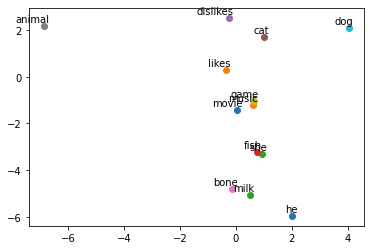

In [60]:
# Get the trained projection matrix
trained_embeddings = W1.data.numpy()
# Visualise result
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    # print (label, " : ", x, " " , y) # uncomment to see the detailed vector info
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()

### Sample Output

In [61]:
# The sample output for model training log (only for format reference)

In [62]:
# The sample output for trained embedding visualization (only for format reference)